In [101]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from convnwb.paths import Paths
from convnwb.io import get_files, load_jsons_to_df, load_matfile
from scipy.stats import binom_test, chi2_contingency
from spiketools.plts.annotate import add_vlines,add_hlines
from spiketools.plts.data import plot_hist
from spiketools.plts.utils import make_axes
from spiketools.plts.utils import make_grid, get_grid_subplot, save_figure
from spiketools.plts.style import drop_spines
from spiketools.utils.run import create_methods_list

In [102]:
import seaborn as sns
sns.set_context('talk', font_scale=0.9)

In [103]:
import sys
sys.path.append('../code')
from utils import get_significant_percentage, get_agreement_percentage
from plts import plot_percentages

sys.path.append('../scripts')
from settings import RUN, PATHS, UNITS,METHODS, SURROGATES

In [104]:
results_folder = PATHS['RESULTS'] / 'units_matlab_sensitivitycheck'
reports_folder = PATHS['REPORTS'] / 'units_matlab_sensitivitycheck'

locations_folder = PATHS['BASE'] / 'localization'/'Loc'
jacksheet_folder = PATHS['BASE'] / 'localization'/'jacksheet'
locations_files = get_files(locations_folder, select='session_data')
locations_files

['session_data.json']

In [105]:
Locations = load_jsons_to_df(locations_files, folder=locations_folder)


In [106]:
res_files = get_files(results_folder, select='mat')

In [107]:
all_results = load_jsons_to_df(res_files, folder=results_folder)

In [132]:
all_results['place_info']

0      0.000729
1      0.015929
2      0.006752
3      0.080661
4      0.018952
         ...   
385    0.104966
386    0.001962
387    0.000267
388    0.000447
389    0.007260
Name: place_info, Length: 390, dtype: float64

In [109]:
# Get total number of units
n_units = len(all_results)
print('Total number of cells: {}'.format(n_units))
# Collect numbers of significant cells
analyses = create_methods_list(METHODS)
# Statistics settings
alpha_level = 0.05
binom_sidedness = 'greater'   
results = {}
for analysis in analyses:
    all_results[f'is_{analysis}'] = (all_results[f'{analysis}_surr_p_val'] < alpha_level).values

for analysis in analyses:
     results[analysis] = sum(all_results['is_' + analysis])


# Compute significance of the counts of detected neurons
stats = {}
for analysis in analyses:
    stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)

Total number of cells: 390


/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_2933/901725631.py:20: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  stats[analysis] = binom_test(results[analysis], n_units, alpha_level, binom_sidedness)


In [110]:
print('total cells: {}\n'.format( n_units))
for analysis in analyses:
    print('# {} cells:     \t\t{:3d}  ({:5.2f}%) \t\t {:.4f}'.format(\
        analysis, results[analysis], results[analysis] / n_units * 100, stats[analysis]))

total cells: 390

# place_anova cells:     		 83  (21.28%) 		 0.0000
# place_info cells:     		 80  (20.51%) 		 0.0000
# place_fr_anova cells:     		 55  (14.10%) 		 0.0000
# place_fr_info cells:     		 57  (14.62%) 		 0.0000


In [133]:
spike_names = all_results['spike_name']
labels = all_results['label']

In [134]:
all_results['channel'] = spike_names.str.extract(r'(?:NSX|CSC)(\d+)')[0].str.lstrip('0')
all_results['sessions'] = all_results['session_id'].str.extract(r'(\w+)_(\d+)_train_events.mat')[0] + '_' + all_results['session_id'].str.extract(r'(\w+)_(\d+)_train_events.mat')[1]


In [135]:
all_results['location'] = None
for i in range(len(all_results['session_id'])):
    session_id = all_results['sessions'][i]
    channel = int(all_results['channel'][i])
    if session_id in Locations:
        
        if channel in Locations[session_id][0]['LFPChan']:
            # get the index of the channel in the LFPChan list
            channel_idx = Locations[session_id][0]['LFPChan'].index(channel)
            all_results['location'][i] = Locations[session_id][0]['LFPArea'][channel_idx]
            print(f"Location: {all_results['location'][i]}")
        else:
            all_results['location'][i] = None
    else:
        all_results['location'][i] = None

Location: LA_2
Location: LA_2
Location: LA_2
Location: LA_2
Location: LA_2
Location: LA_2
Location: RCA1_2
Location: RCA1_2
Location: RCA1_3
Location: RCA1_3
Location: RCA1_5
Location: RCA1_5
Location: RCA1_11
Location: LA_2
Location: LA_2
Location: LA_2
Location: LA_2
Location: LA_3
Location: LA_4
Location: LA_4
Location: LA_4
Location: LA_4
Location: LA_4
Location: LA_5
Location: LA_5
Location: LA_5
Location: LA_5
Location: LA_6
Location: LA_7
Location: LA_7
Location: LA_7
Location: LA_7
Location: LA_8
Location: LSB_2
Location: LSB_2
Location: LSB_2
Location: LSB_5
Location: LA_2
Location: LA_2
Location: LA_3
Location: LA_5
Location: LA_5
Location: LA_6
Location: LA_7
Location: LA_8
Location: LA_9
Location: LA_12
Location: LA_12
Location: LA_16
Location: LCA1_5
Location: LA_2
Location: LA_5
Location: LA_6
Location: LA_8
Location: LA_11
Location: LA_12
Location: LA_12
Location: LA_12
Location: LA_12
Location: LA_14
Location: LA_16
Location: LA_6
Location: LA_6
Location: LA_8
Location:

/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_2933/2921698974.py:15: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  all_results['location'][i] = None
/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_2933/2921698974.py:1

In [136]:
len(all_results['location'].values[~pd.isna(all_results['location'].values)])



354

In [137]:
all_results['location_clean'] = all_results['location'].str.replace(r'^[LR]|_\d+$', '', regex=True)

# Reorder hippocampal areas together and combine cingulate areas
anatomy_counts = all_results['location_clean'].value_counts()
hippo_areas = ['CA1', 'PHG','SB','DG']  # Only CA1 and PHG
cingulate_areas = ['MC', 'AC']  # Cingulate areas to combine
hippo_counts = anatomy_counts[anatomy_counts.index.isin(hippo_areas)].sum()  # Sum CA1 and PHG counts
cingulate_counts = anatomy_counts[anatomy_counts.index.isin(cingulate_areas)].sum()  # Sum cingulate counts
other_counts = anatomy_counts[~anatomy_counts.index.isin(hippo_areas + cingulate_areas)]
# Create a new Series with the combined counts
anatomy_counts = pd.concat([
    pd.Series({'Hippocampus': hippo_counts, 'Cingulate': cingulate_counts}), 
    other_counts
])

# Calculate total number of cells with valid anatomy 
total_cells = anatomy_counts[~anatomy_counts.index.isna()].sum()
print(f"Total number of cells with valid anatomical locations: {total_cells}")

# Display the counts
print("\nAnatomical Location Counts:")
print("-" * 30)
for location, count in anatomy_counts.items():
    if pd.notna(location):
        print(f"{location}: {int(count)}")

Total number of cells with valid anatomical locations: 354

Anatomical Location Counts:
------------------------------
Hippocampus: 99
Cingulate: 39
EC: 124
A: 79
WM: 10
CS: 3


## Apply Exclusion Criteria 

In [138]:
from copy import deepcopy

# Display the original dataframe before filtering
print("Original dataframe shape:", all_results.shape)
print(all_results.columns)
all_results['firing_rate'] = all_results['place_bins'].apply(lambda x: np.mean(x))

# Create a filtered copy
results = deepcopy(all_results)

results = results[all_results['firing_rate'].astype(float) < 20]
results = results[all_results['firing_rate'].astype(float) > .1]
# Display the filtered dataframe
print("\nFiltered dataframe shape:", results.shape)

Original dataframe shape: (390, 32)
Index(['unit_ind', 'session_id', 'label', 'spike_name', 'place_bins',
       'trial_place_bins', 'place_sem', 'trial_fr', 'fr_bins', 'fr_sem',
       's_bins', 'place_info', 'place_fr_info', 'place_anova',
       'place_fr_anova', 'place_anova_surr_p_val', 'place_anova_surr_z_score',
       'place_info_surr_p_val', 'place_info_surr_z_score',
       'place_fr_anova_surr_p_val', 'place_fr_anova_surr_z_score',
       'place_fr_info_surr_p_val', 'place_fr_info_surr_z_score',
       'is_place_anova', 'is_place_info', 'is_place_fr_anova',
       'is_place_fr_info', 'channel', 'sessions', 'location', 'location_clean',
       'firing_rate'],
      dtype='object')

Filtered dataframe shape: (292, 32)


/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_2933/3162939180.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results = results[all_results['firing_rate'].astype(float) > .1]


In [150]:
results['location_clean'] = results['location_clean'].replace(['CA1', 'PHG','SB','DG'], 'H')
results['location_clean'] = results['location_clean'].replace(['MC', 'AC'], 'C')
# Drop WM (white matter) from the dataset
results = results[results['location_clean'] != 'WM']


In [151]:
region_sig_info = results[results['place_info_surr_p_val'] < 0.05].groupby('location_clean')['unit_ind'].count()
region_sig_anova = results[results['place_anova_surr_p_val'] < 0.05].groupby('location_clean')['unit_ind'].count()
region_sig_info_threshold = results[results['place_info'] > 0.25].groupby('location_clean')['unit_ind'].count()
region_total_info = results.groupby('location_clean')['unit_ind'].count()
region_info_pct = (region_sig_info / region_total_info * 100).round(2)
region_anova_pct = (region_sig_anova / region_total_info * 100).round(2)
region_info_threshold_pct = (region_sig_info_threshold / region_total_info * 100).round(2)


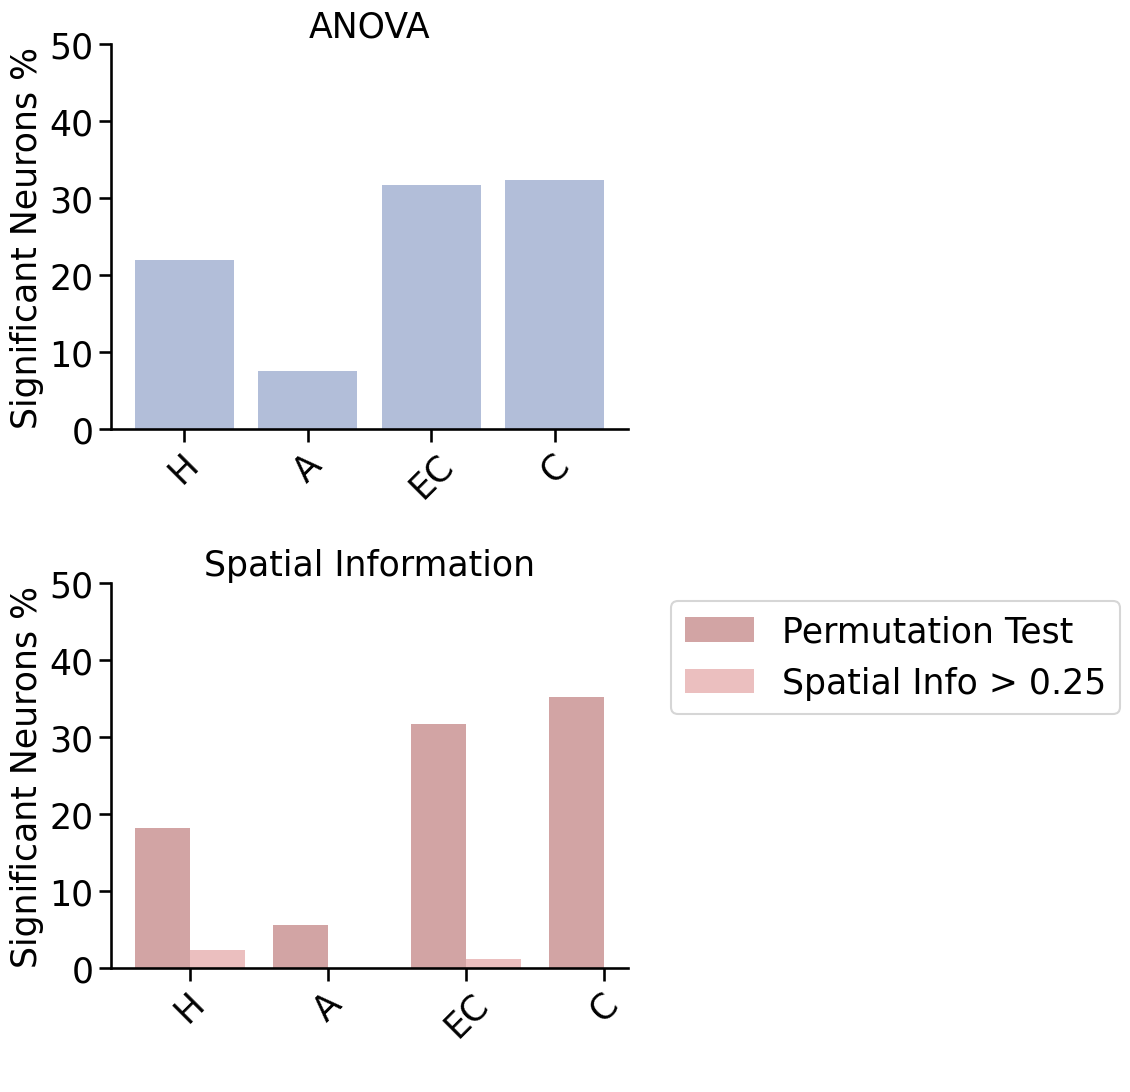

In [153]:
grid = make_grid(2, 2, wspace=.4, hspace=.4, figsize=(16, 12))

plt.rcParams.update({
    'font.size': 25,
    'axes.titlesize': 25,
    'axes.labelsize': 25,
    'legend.fontsize': 25,
    'xtick.labelsize': 25,
    'ytick.labelsize': 25
})

desired_order = ['H', 'A', 'EC', 'C']
# Reorder regions according to desired order
region_info_pct_ordered = region_info_pct.reindex(desired_order)
region_anova_pct_ordered = region_anova_pct.reindex(desired_order)
region_info_threshold_pct_ordered = region_info_threshold_pct.reindex(desired_order)

x = np.arange(len(desired_order))
width = 0.8
ax=get_grid_subplot(grid,1, 0)
# Plot for spatial information
ax.bar(x - width/4, region_info_pct_ordered, width/2, label='Permutation Test', color='#c78e8e', alpha=0.8)
ax.bar(x + width/4, region_info_threshold_pct_ordered, width/2, label='Spatial Info > 0.25', color='#e6b0b0', alpha=0.8)
ax.set_ylabel('Significant Neurons %')
ax.set_xticks(x)
ax.set_xticklabels(desired_order, rotation=45)
ax.set_xlabel(' ')
ax.set_title('Spatial Information')
ax.set_ylim(0, 50) # Increased y-limit to accommodate labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


ax=get_grid_subplot(grid,0, 0)

# Plot for ANOVA
ax.bar(x, region_anova_pct_ordered, width, label='ANOVA', color='#7f94c0', alpha=0.6)

ax.set_ylabel('Significant Neurons %')
ax.set_xticks(x)
ax.set_xticklabels(desired_order, rotation=45)
ax.set_xlabel(' ')
ax.set_title('ANOVA')
ax.set_ylim(0, 50) # Increased y-limit to accommodate labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
save_figure('ANATOMY_REGION_SIGNIFICANCE_Smooth',file_path='/Users/weijiazhang/Plots/PLDM/Human')

## Define Threshold

In [162]:
threshold_info = 0.25
threshold_p_val = 0.05

print('threshold_info: ', threshold_info)
print('threshold_p_val: ', threshold_p_val)

threshold_info:  0.25
threshold_p_val:  0.05


In [163]:
results.columns

Index(['unit_ind', 'session_id', 'label', 'spike_name', 'place_bins',
       'trial_place_bins', 'place_sem', 'trial_fr', 'fr_bins', 'fr_sem',
       's_bins', 'place_info', 'place_fr_info', 'place_anova',
       'place_fr_anova', 'place_anova_surr_p_val', 'place_anova_surr_z_score',
       'place_info_surr_p_val', 'place_info_surr_z_score',
       'place_fr_anova_surr_p_val', 'place_fr_anova_surr_z_score',
       'place_fr_info_surr_p_val', 'place_fr_info_surr_z_score',
       'is_place_anova', 'is_place_info', 'is_place_fr_anova',
       'is_place_fr_info', 'channel', 'sessions', 'location', 'location_clean',
       'firing_rate'],
      dtype='object')

In [182]:
place_info = results['place_info']

place_anova = results['place_anova']

place_info_surr_p_val = results['place_info_surr_p_val']

place_anova_surr_p_val = results['place_anova_surr_p_val']

In [183]:
total_cells = len(results)


## SI permutation vs. ANOVA permutation

In [184]:
both_significant = np.sum((place_anova_surr_p_val < threshold_p_val) & (place_info_surr_p_val < threshold_p_val))
both_significant_pct = (both_significant / total_cells) * 100

anova_significant = np.sum((place_anova_surr_p_val < threshold_p_val) & ~(place_info_surr_p_val < threshold_p_val))
anova_significant_pct = (anova_significant / total_cells) * 100

info_significant = np.sum(~(place_anova_surr_p_val < threshold_p_val) & (place_info_surr_p_val < threshold_p_val))
info_significant_pct = (info_significant / total_cells) * 100

both_not_significant = np.sum(~(place_anova_surr_p_val < threshold_p_val) & ~(place_info_surr_p_val < threshold_p_val))
both_not_significant_pct = (both_not_significant / total_cells) * 100

data = np.array([
    [anova_significant_pct, both_not_significant_pct],
    [both_significant_pct, info_significant_pct]
])

SI_permutation_v_ANOVA_permutation_df = pd.DataFrame(data, index=['N.S.', '*'],
                  columns=['*', 'N.S.'])

anova_significant = anova_significant_pct+both_significant_pct
info_significant = info_significant_pct+both_significant_pct

print('anova_significant: ', anova_significant)
print('info_significant: ', info_significant)



anova_significant:  22.887323943661972
info_significant:  22.183098591549296


## SI Threshold  Vs. ANOVA Permutation

In [194]:
both_significant = np.sum((place_anova_surr_p_val < threshold_p_val) & (place_info > threshold_info))
both_significant_pct = (both_significant / total_cells) * 100

anova_significant = np.sum((place_anova_surr_p_val < threshold_p_val) & ~(place_info > threshold_info))
anova_significant_pct = (anova_significant / total_cells) * 100

info_significant = np.sum(~(place_anova_surr_p_val < threshold_p_val) & (place_info > threshold_info))
info_significant_pct = (info_significant / total_cells) * 100

both_not_significant = np.sum(~(place_anova_surr_p_val < threshold_p_val) & ~(place_info > threshold_info))
both_not_significant_pct = (both_not_significant / total_cells) * 100

data = np.array([
    [anova_significant_pct, both_not_significant_pct],
    [both_significant_pct, info_significant_pct]
])

SI_threshold_v_ANOVA_permutation_df = pd.DataFrame(data, index=['N.S.', '*'],
                  columns=['*', 'N.S.'])

anova_significant = anova_significant_pct+both_significant_pct
info_significant = info_significant_pct+both_significant_pct

print('anova_significant: ', anova_significant)
print('info_significant: ', info_significant)


anova_significant:  22.887323943661976
info_significant:  1.0563380281690142


## SI Threshold  Vs. SI Permutation

In [195]:
both_significant = np.sum((place_info_surr_p_val < threshold_p_val) & (place_info > threshold_info))
both_significant_pct = (both_significant / total_cells) * 100

info_significant = np.sum((place_info_surr_p_val < threshold_p_val) & ~(place_info > threshold_info))
info_significant_pct = (info_significant / total_cells) * 100

info_threshold = np.sum(~(place_info_surr_p_val < threshold_p_val) & (place_info > threshold_info))
info_threshold_pct = (info_threshold / total_cells) * 100

both_not_significant = np.sum(~(place_info_surr_p_val < threshold_p_val) & ~(place_info > threshold_info))
both_not_significant_pct = (both_not_significant / total_cells) * 100

data = np.array([
    [info_significant_pct, both_not_significant_pct],
    [both_significant_pct, info_threshold_pct]
])

SI_threshold_v_SI_permutation_df = pd.DataFrame(data, index=['N.S.', '*'],
                  columns=['*', 'N.S.'])

info_significant_pct_significant = info_significant_pct+both_significant_pct
info_threshold_pct_significant = info_threshold_pct+both_significant_pct

print('info_significant: ', info_significant_pct_significant)
print('info_threshold: ', info_threshold_pct_significant)

info_significant:  22.183098591549296
info_threshold:  1.0563380281690142


/var/folders/tx/9bxcz_2j6m79n4dmyyw6s2zm0000gn/T/ipykernel_2933/3129525202.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


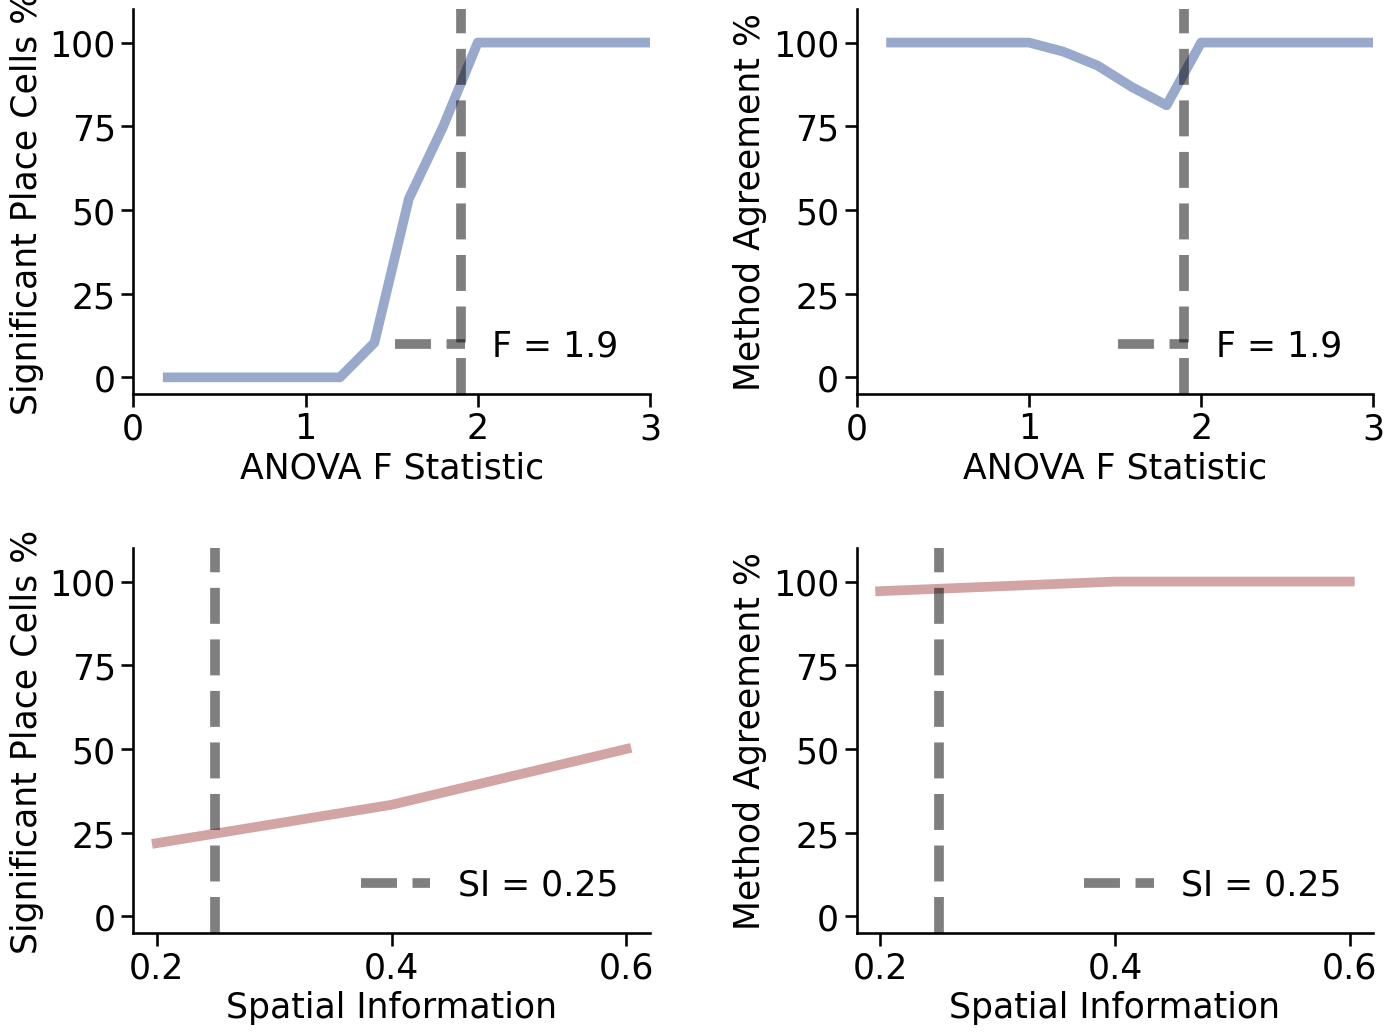

In [ ]:
info_increment = .2
anova_increment = .2

info_steps, info_significant_percentages = get_significant_percentage(results['place_info'].values,results['place_info_surr_p_val'].values,increment=info_increment)
anova_steps, anova_significant_percentages = get_significant_percentage(results['place_anova'].values,results['place_anova_surr_p_val'].values,increment=anova_increment)
info_categories, info_agreement_percentages, _, _ = get_agreement_percentage(results['place_info'].values,results['place_info_surr_p_val'].values,results['place_anova_surr_p_val'].values,increment=info_increment)
anova_categories, anova_agreement_percentages, _, _= get_agreement_percentage(results['place_anova'].values,results['place_anova_surr_p_val'].values,results['place_info_surr_p_val'].values,increment=anova_increment)


grid = make_grid(2, 2, wspace=.4, hspace=.4, figsize=(16, 12))

plt.rcParams.update({
    'font.size': 25,
    'axes.titlesize': 25,
    'axes.labelsize': 25,
    'legend.fontsize': 25,
    'xtick.labelsize': 25,
    'ytick.labelsize': 25
})

# Define consistent colors
anova_color = '#7f94c0'  # Deep blue for ANOVA
info_color = '#c78e8e'   # Deep red for Spatial Info
threshold_color = '#000000'  # Black for threshold lines
lw = 7

# ANOVA Significance Plot
ax = get_grid_subplot(grid, 0, 0)
plot_percentages(anova_steps, anova_significant_percentages, 
                 xlim=[-0,3],ylim=[-5,110],
                ylabel='Significant Place Cells %',
                xlabel='ANOVA F Statistic',
                color=anova_color, lw=lw, alpha=0.8, ax=ax)
add_vlines(1.9, color=threshold_color, linestyle='--',alpha=0.5, lw=lw, label='F = 1.9')
ax.legend(frameon=False, loc='lower right')

drop_spines(['top','right'])

# ANOVA Agreement Plot  
ax = get_grid_subplot(grid, 0, 1)
plot_percentages(anova_steps, anova_agreement_percentages,
                 xlim=[-0,3],ylim=[-5,110],
                ylabel='Method Agreement %', 
                xlabel='ANOVA F Statistic',
                color=anova_color, lw=lw, alpha=0.8, ax=ax)
add_vlines(1.9, color=threshold_color, linestyle='--', lw=lw, alpha=0.5, label='F = 1.9')
ax.legend(frameon=False, loc='lower right')

drop_spines(['top','right'])

# Spatial Information Significance Plot
ax = get_grid_subplot(grid, 1, 0)
plot_percentages(info_steps, info_significant_percentages,
                 ylim=[-5,110],
                ylabel='Significant Place Cells %',
                xlabel='Spatial Information',
                color=info_color, lw=lw, alpha=0.8, ax=ax)
add_vlines(0.25, color=threshold_color, linestyle='--', lw=lw, alpha=0.5, label='SI = 0.25')
ax.legend(frameon=False, loc='lower right')

drop_spines(['top','right'])

# Spatial Information Agreement Plot
ax = get_grid_subplot(grid, 1, 1)
plot_percentages(info_steps, info_agreement_percentages,
              ylim=[-5,110],
                ylabel='Method Agreement %',
                xlabel='Spatial Information', 
                color=info_color, lw=lw, alpha=0.8, ax=ax)
add_vlines(0.25, color=threshold_color, linestyle='--', lw=lw, alpha=0.5, label='SI = 0.25')
ax.legend(frameon=False, loc='lower right')

drop_spines(['top','right'])
save_figure('Percentage_Significance_Agreement',file_path='/Users/weijiazhang/Plots/PLDM/Human')

plt.tight_layout()

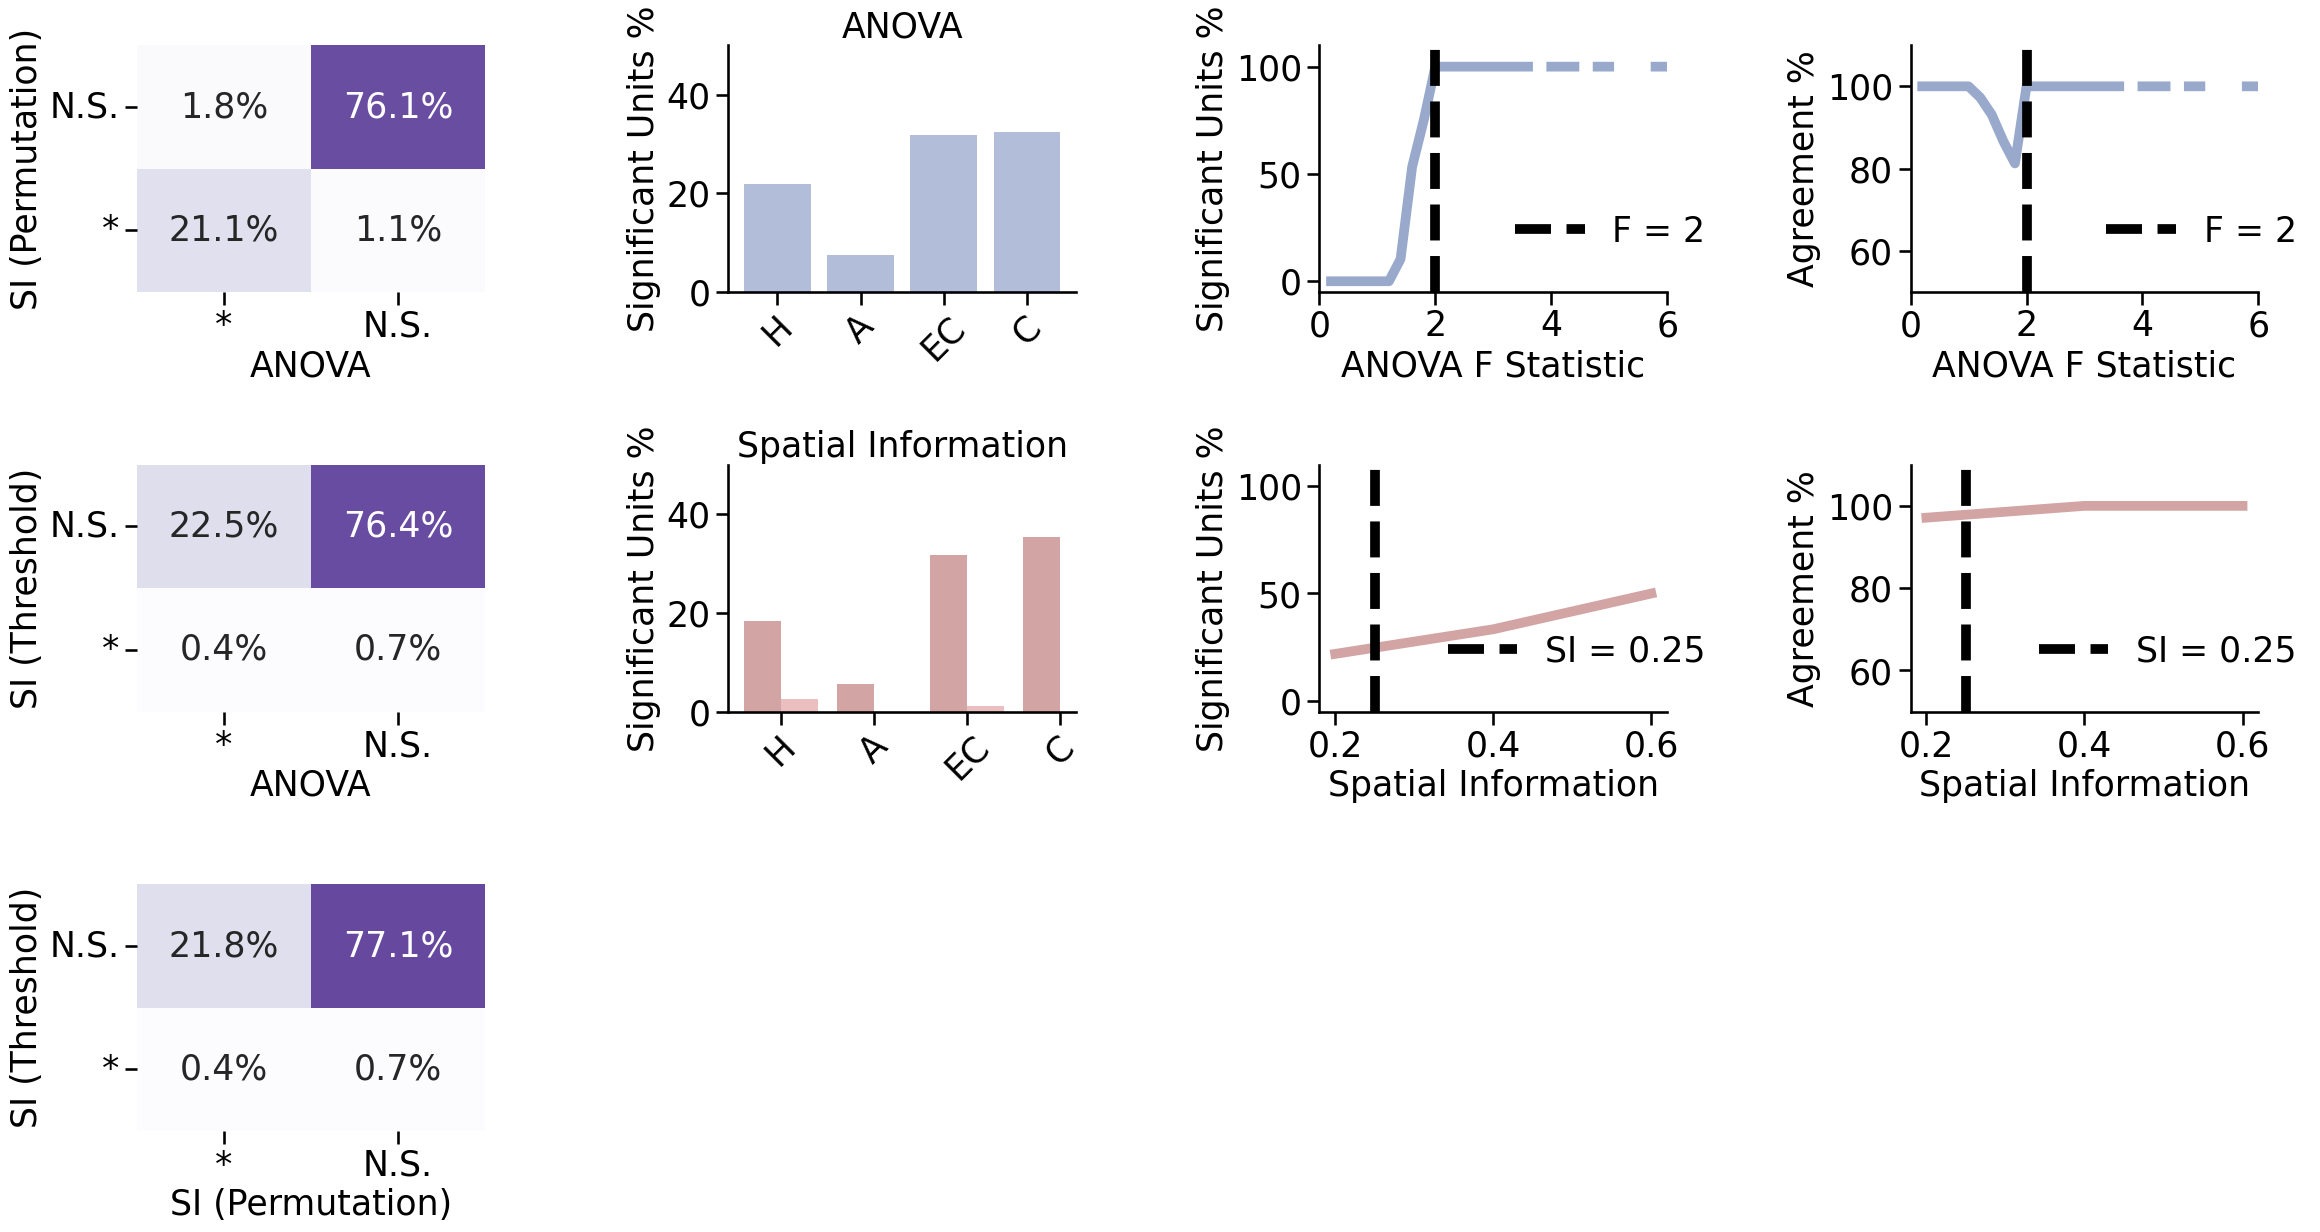

In [249]:
# Make grid for plotting
grid = make_grid(5, 5, wspace=.7, hspace=.7, figsize=(35, 25))

plt.rcParams.update({
    'font.size': 25,
    'axes.titlesize': 25,
    'axes.labelsize': 25,
    'legend.fontsize': 25,
    'xtick.labelsize': 25,
    'ytick.labelsize': 25
})
# Plotting the heatmap
ax = get_grid_subplot(grid, 0, 1)
heatmap = sns.heatmap(SI_permutation_v_ANOVA_permutation_df, annot=True, fmt='.1f', cmap='Purples', vmin=0, vmax=100, ax=ax, cbar=False)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0, ha='center')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
heatmap.set_xlabel('ANOVA')
heatmap.set_ylabel('SI (Permutation)')
#heatmap.set_title('Average of Forward and Backward')
# Add % symbol to annotations
for t in heatmap.texts:
    t.set_text(t.get_text() + '%')

ax = get_grid_subplot(grid, 1, 1)
heatmap = sns.heatmap(SI_threshold_v_ANOVA_permutation_df, annot=True, fmt='.1f', cmap='Purples', vmin=0, vmax=100, ax=ax, cbar=False)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0, ha='center')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
heatmap.set_xlabel('ANOVA')
heatmap.set_ylabel('SI (Threshold)')
#heatmap.set_title('Average of Forward and Backward')
# Add % symbol to annotations
for t in heatmap.texts:
    t.set_text(t.get_text() + '%')

ax = get_grid_subplot(grid, 2, 1)
heatmap = sns.heatmap(SI_threshold_v_SI_permutation_df, annot=True, fmt='.1f', cmap='Purples', vmin=0, vmax=100, ax=ax, cbar=False)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0, ha='center')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
heatmap.set_xlabel('SI (Permutation)')
heatmap.set_ylabel('SI (Threshold)')
# Add % symbol to annotations
for t in heatmap.texts:
    t.set_text(t.get_text() + '%')


desired_order = ['H', 'A', 'EC', 'C']
# Reorder regions according to desired order
region_info_pct_ordered = region_info_pct.reindex(desired_order)
region_anova_pct_ordered = region_anova_pct.reindex(desired_order)
region_info_threshold_pct_ordered = region_info_threshold_pct.reindex(desired_order)

x = np.arange(len(desired_order))
width = 0.8
ax=get_grid_subplot(grid,1, 2)
# Plot for spatial information
ax.bar(x - width/4, region_info_pct_ordered, width/2, label='Permutation Test', color='#c78e8e', alpha=0.8)
ax.bar(x + width/4, region_info_threshold_pct_ordered, width/2, label='Spatial Info > 0.25', color='#e6b0b0', alpha=0.8)
ax.set_ylabel('Significant Units %')
ax.set_xticks(x)
ax.set_xticklabels(desired_order, rotation=45)
ax.set_xlabel(' ')
ax.set_title('Spatial Information')
ax.set_ylim(0, 50) # Increased y-limit to accommodate labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


ax=get_grid_subplot(grid,0, 2)

# Plot for ANOVA
ax.bar(x, region_anova_pct_ordered, width, label='ANOVA', color='#7f94c0', alpha=0.6)

ax.set_ylabel('Significant Units %')
ax.set_xticks(x)
ax.set_xticklabels(desired_order, rotation=45)
ax.set_xlabel(' ')
ax.set_title('ANOVA')
ax.set_ylim(0, 50) # Increased y-limit to accommodate labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax = get_grid_subplot(grid, 0, 3)
plot_percentages(anova_steps, anova_significant_percentages, 
                 xlim=[-0,6],ylim=[-5,110],
                ylabel='Significant Units %',
                xlabel='ANOVA F Statistic',
                color=anova_color, lw=lw, alpha=0.8, ax=ax)
add_vlines(2, color=threshold_color, linestyle='--',alpha=1, lw=lw, label='F = 2')
ax.legend(frameon=False, loc='lower right', bbox_to_anchor=(1.2, 0.05))

drop_spines(['top','right'])

# ANOVA Agreement Plot  
ax = get_grid_subplot(grid, 0, 4)
plot_percentages(anova_steps, anova_agreement_percentages,
                 xlim=[-0,6],ylim=[50,110],
                ylabel='Agreement %', 
                xlabel='ANOVA F Statistic',
                color=anova_color, lw=lw, alpha=0.8, ax=ax)
add_vlines(2, color=threshold_color, linestyle='--', lw=lw, alpha=1, label='F = 2')
ax.legend(frameon=False, loc='lower right', bbox_to_anchor=(1.2, 0.05))


drop_spines(['top','right'])

# Spatial Information Significance Plot
ax = get_grid_subplot(grid, 1, 3)
plot_percentages(info_steps, info_significant_percentages,
                 ylim=[-5,110],
                ylabel='Significant Units %',
                xlabel='Spatial Information',
                color=info_color, lw=lw, alpha=0.8, ax=ax)
add_vlines(0.25, color=threshold_color, linestyle='--', lw=lw, alpha=1, label='SI = 0.25')
ax.legend(frameon=False, loc='lower right', bbox_to_anchor=(1.2, 0.05))

drop_spines(['top','right'])

# Spatial Information Agreement Plot
ax = get_grid_subplot(grid, 1, 4)
plot_percentages(info_steps, info_agreement_percentages,
              ylim=[50,110],
                ylabel='Agreement %',
                xlabel='Spatial Information', 
                color=info_color, lw=lw, alpha=0.8, ax=ax)
add_vlines(0.25, color=threshold_color, linestyle='--', lw=lw, alpha=1, label='SI = 0.25')
ax.legend(frameon=False, loc='lower right', bbox_to_anchor=(1.2, 0.05))

#save_figure('Figure_HUman',file_path='/Users/weijiazhang/Plots/PLDM/Human')


drop_spines(['top','right'])
save_figure('Figure_HUman',file_path='/Users/weijiazhang/Plots/PLDM/Human')